In [97]:
print("ok")

ok


In [98]:
import sys, os

In [99]:
# Get project root — one level up from 'research_and_analyst'
# project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
# sys.path.append(project_root)

# print("Project root added to path:", project_root)

In [100]:
from research_and_analyst.utils.model_loader import ModelLoader

In [101]:
model_loader = ModelLoader()

{"timestamp": "2025-11-27T09:49:14.256855Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-11-27T09:49:14.262172Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-27T09:49:14.262172Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-27T09:49:14.264928Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-11-27T09:49:14.264928Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-11-27T09:49:14.264928Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-27T09:49:14.274242Z", "level": "info", "event": "YAML config loaded"}


In [102]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-11-27T09:49:14.283204Z", "level": "info", "event": "Loading LLM"}


In [103]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [104]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [105]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

## health

Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), 

Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [106]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [107]:
Analyst(
    name="suman",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='suman', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [108]:
analyst=Analyst(
    name="suman",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor")

In [109]:
analyst.name

'suman'

In [110]:
analyst.role

'genai eng'

In [111]:
analyst.affiliation

'AI Research LAB'

In [112]:
analyst.description

'I am genai developer as well as mentor'

In [113]:
print(analyst.persona)

Name: suman
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [114]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [115]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [116]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)


{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [117]:
Analyst(
    name= "Dr. Neha Patel",
    role="Medical Data Scientist",
    affiliation= "Stanford Medicine",
    description= "Focuses on predictive models for patient outcomes."
)

Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.')

In [118]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [119]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [120]:
# class GenerateAnalystsState(TypedDict):
#     topic: str #research topic
#     max_analysts: int # number of analyst
#     human_analyst_feedback: str # Human feedback
#     analysts: List[Analyst] # Analyst asking questions



# class Perspectives(BaseModel):
#     analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")


In [121]:

def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [122]:
create_analyst(
    {'topic': 'health',
     'max_analysts':2,
     'human_analyst_feedback': 'give the real info'}
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Analyst', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends, particularly the impact of pandemics on public health systems. Her primary concern is understanding how health policies can be optimized to improve health outcomes in diverse populations. She is motivated by the need to prepare for future health crises by analyzing past and current data to inform policy decisions.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard T.H. Chan School of Public Health', description='Dr. Raj Patel specializes in the intersection of technology and healthcare, with a focus on how digital health innovations can improve patient care and health system efficiency. His concerns include the ethical implications of health data usage and the accessibility of technology-driven health solutions. He is driven by the potential of technology to transform h

In [123]:
# class Analyst(BaseModel):
#     name: str = Field(description="Name of the analyst.")
#     role: str = Field(description="Role of the analyst in the context of the topic.")
#     affiliation: str = Field(description="Primary affiliation of the analyst.")
#     description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
#     @property
#     def persona(self) -> str:
#         return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [124]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass


In [125]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [126]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [127]:
from IPython.display import Image, display

## First Workflow

In [128]:
builder= StateGraph(GenerateAnalystsState)

In [129]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [130]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",should_continue,
                              ["create_analyst",END])

In [131]:
memory=MemorySaver()

In [132]:
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

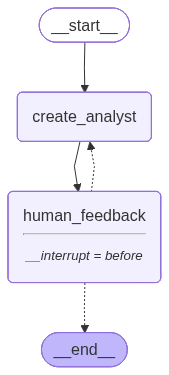

In [133]:

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [134]:
topic= "the benifits of adopting Langraph as an agent framework"
max_analysts=4


In [135]:
thread={"configurable":{"thread_id":1}}

In [136]:
for event in graph.stream({"topic":topic,"max_analysts":max_analysts},thread,stream_mode="values"):
    print("event",event)
    print('-----------------------------------------------------------------------')
    analysts = event.get('analysts', '')
    print('analysts::',analysts)
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

event {'topic': 'the benifits of adopting Langraph as an agent framework', 'max_analysts': 4}
-----------------------------------------------------------------------
analysts:: 


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


event {'topic': 'the benifits of adopting Langraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the comparative analysis of AI frameworks. She is particularly interested in how Langraph enhances agent-based modeling and simulation, offering improved scalability and flexibility over traditional frameworks. Her research aims to identify key performance metrics that demonstrate Langraph's superiority in complex system simulations."), Analyst(name='Raj Patel', role='Software Developer', affiliation='Tech Innovators Inc.', description='Raj is a software developer with a keen interest in integrating new technologies into existing systems. He is focused on the practical benefits of adopting Langraph, such as ease of integration, reduced development time, and enhanced system interoperability. Raj is motivated by the potential for Langraph to

In [137]:
state=graph.get_state(thread)

In [138]:
state

StateSnapshot(values={'topic': 'the benifits of adopting Langraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the comparative analysis of AI frameworks. She is particularly interested in how Langraph enhances agent-based modeling and simulation, offering improved scalability and flexibility over traditional frameworks. Her research aims to identify key performance metrics that demonstrate Langraph's superiority in complex system simulations."), Analyst(name='Raj Patel', role='Software Developer', affiliation='Tech Innovators Inc.', description='Raj is a software developer with a keen interest in integrating new technologies into existing systems. He is focused on the practical benefits of adopting Langraph, such as ease of integration, reduced development time, and enhanced system interoperability. Raj is motivated by the potential 

In [139]:
print('state',state.values)

state 

{'topic': 'the benifits of adopting Langraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the comparative analysis of AI frameworks. She is particularly interested in how Langraph enhances agent-based modeling and simulation, offering improved scalability and flexibility over traditional frameworks. Her research aims to identify key performance metrics that demonstrate Langraph's superiority in complex system simulations."), Analyst(name='Raj Patel', role='Software Developer', affiliation='Tech Innovators Inc.', description='Raj is a software developer with a keen interest in integrating new technologies into existing systems. He is focused on the practical benefits of adopting Langraph, such as ease of integration, reduced development time, and enhanced system interoperability. Raj is motivated by the potential for Langraph to strea

In [140]:
state.values

{'topic': 'the benifits of adopting Langraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the comparative analysis of AI frameworks. She is particularly interested in how Langraph enhances agent-based modeling and simulation, offering improved scalability and flexibility over traditional frameworks. Her research aims to identify key performance metrics that demonstrate Langraph's superiority in complex system simulations."),
  Analyst(name='Raj Patel', role='Software Developer', affiliation='Tech Innovators Inc.', description='Raj is a software developer with a keen interest in integrating new technologies into existing systems. He is focused on the practical benefits of adopting Langraph, such as ease of integration, reduced development time, and enhanced system interoperability. Raj is motivated by the potential for Langraph to s

In [141]:
# class GenerateAnalystsState(TypedDict):
#     topic: str #research topic
#     max_analysts: int # number of analyst
#     human_analyst_feedback: str # Human feedback
#     analysts: List[Analyst] # Analyst asking questions



# class Perspectives(BaseModel):
#     analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")


In [142]:
state.next

('human_feedback',)

In [143]:
memory.storage

defaultdict(<function langgraph.checkpoint.memory.InMemorySaver.__init__.<locals>.<lambda>()>,
            {'1': defaultdict(dict,
                         {'': {'1f0cb765-8ec0-6100-bfff-2ba3775846b4': (('msgpack',
                             b'\x86\xa1v\x04\xa2ts\xd9 2025-11-27T09:49:20.692659+00:00\xa2id\xd9$1f0cb765-8ec0-6100-bfff-2ba3775846b4\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.7368783299240502\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'),
                            ('msgpack',
                             b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'),
                            None),
                           '1f0cb765-8ec9-6051-8000-8d937d28d768': (('msgpack',
                             b'\x86\xa1v\x04\xa2ts\xd9 2025-11-27T09:49:20.696328+00:00\xa2id\xd9$1f0cb765-8ec9-6051-8000-8d937d28d768\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5756180370574956\xa5topic\xd

In [144]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0cb765-8ec0-6100-bfff-2ba3775846b4': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-27T09:49:20.692659+00:00\xa2id\xd9$1f0cb765-8ec0-6100-bfff-2ba3775846b4\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.7368783299240502\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0cb765-8ec9-6051-8000-8d937d28d768': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-27T09:49:20.696328+00:00\xa2id\xd9$1f0cb765-8ec9-6051-8000-8d937d28d768\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5756180370574956\xa5topic\xd9300000000000000000000000000000002.0.5756180370574956\xacmax_analysts\xd9300000000000000000000000000000002.0.5756180370574956\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.5756180370574956\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd

In [145]:
pip install msgpack

Note: you may need to restart the kernel to use updated packages.


In [146]:

# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)

In [147]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cb765-d495-63e8-8001-f04286c39273'}}

In [148]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cb765-df63-6a8e-8002-41ae0e187b69'}}

In [149]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks. She is particularly interested in how Langraph enhances agent-based modeling and simulation, offering improved scalability and flexibility over traditional frameworks. Her research aims to identify key performance metrics that demonstrate Langraph's superiority in complex system simulations.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Software Developer
Description: Raj is a software developer with a keen interest in integrating new technologies into existing systems. He is focused on the practical benefits of adopting Langraph, such as ease of integration, reduced development time, and enhanced system interoperability. Raj is motivated by the potential for Langraph to streamline development processes and improve software efficiency.
--------------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Chen
Affiliation: Tech Innovations Inc.
Role: Enterprise Technology Strategist
Description: Sophia focuses on the strategic implementation of cutting-edge technologies within large enterprises. Her primary concern is how adopting Langraph as an agent framework can streamline operations, enhance scalability, and improve integration with existing enterprise systems. She is particularly interested in the latest applications of Langraph in enterprise environments and how it can drive digital transformation.
--------------------------------------------------
Name: Raj Patel
Affiliation: Venture Growth Partners
Role: Startup Ecosystem Analyst
Description: Raj specializes in analyzing the startup ecosystem, with a keen interest in how emerging technologies can provide competitive advantages. He examines how Langraph can be leveraged by startups to accelerate product development, reduce time-to-market, and optimize resource allocation. Raj is motivated by understanding how startup

In [150]:
state = graph.get_state(thread)

In [151]:
state

StateSnapshot(values={'topic': 'the benifits of adopting Langraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Chen', role='Enterprise Technology Strategist', affiliation='Tech Innovations Inc.', description='Sophia focuses on the strategic implementation of cutting-edge technologies within large enterprises. Her primary concern is how adopting Langraph as an agent framework can streamline operations, enhance scalability, and improve integration with existing enterprise systems. She is particularly interested in the latest applications of Langraph in enterprise environments and how it can drive digital transformation.'), Analyst(name='Raj Patel', role='Startup Ecosystem Analyst', affiliation='Venture Growth Partners', description='Raj specializes in analyzing the startup ecosystem, with a keen interest in how emerging technologies can pr

In [152]:
state.next

('human_feedback',)

In [153]:

state.values

{'topic': 'the benifits of adopting Langraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Chen', role='Enterprise Technology Strategist', affiliation='Tech Innovations Inc.', description='Sophia focuses on the strategic implementation of cutting-edge technologies within large enterprises. Her primary concern is how adopting Langraph as an agent framework can streamline operations, enhance scalability, and improve integration with existing enterprise systems. She is particularly interested in the latest applications of Langraph in enterprise environments and how it can drive digital transformation.'),
  Analyst(name='Raj Patel', role='Startup Ecosystem Analyst', affiliation='Venture Growth Partners', description='Raj specializes in analyzing the startup ecosystem, with a keen interest in how emerging technologies can provide competitiv

In [154]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [155]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config
cfg

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cb766-245c-6212-8005-658b025fccbe'}}

In [156]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cb766-2610-6d7d-8006-a5d7da3013b7'}}

In [157]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

()


In [158]:
analysts = final_state.values.get('analysts')

In [159]:
analysts

[Analyst(name='Sophia Chen', role='Enterprise Technology Strategist', affiliation='Tech Innovations Inc.', description='Sophia focuses on the strategic implementation of cutting-edge technologies within large enterprises. Her primary concern is how adopting Langraph as an agent framework can streamline operations, enhance scalability, and improve integration with existing enterprise systems. She is particularly interested in the latest applications of Langraph in enterprise environments and how it can drive digital transformation.'),
 Analyst(name='Raj Patel', role='Startup Ecosystem Analyst', affiliation='Venture Growth Partners', description='Raj specializes in analyzing the startup ecosystem, with a keen interest in how emerging technologies can provide competitive advantages. He examines how Langraph can be leveraged by startups to accelerate product development, reduce time-to-market, and optimize resource allocation. Raj is motivated by understanding how startups can use Langraph

In [160]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Chen
Affiliation: Tech Innovations Inc.
Role: Enterprise Technology Strategist
Description: Sophia focuses on the strategic implementation of cutting-edge technologies within large enterprises. Her primary concern is how adopting Langraph as an agent framework can streamline operations, enhance scalability, and improve integration with existing enterprise systems. She is particularly interested in the latest applications of Langraph in enterprise environments and how it can drive digital transformation.
--------------------------------------------------
Name: Raj Patel
Affiliation: Venture Growth Partners
Role: Startup Ecosystem Analyst
Description: Raj specializes in analyzing the startup ecosystem, with a keen interest in how emerging technologies can provide competitive advantages. He examines how Langraph can be leveraged by startups to accelerate product development, reduce time-to-market, and optimize resource allocation. Raj is motivated by understanding how startup

In [161]:
# "The benefits of adopting LangGraph as an agent framework"

In [162]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="The benefits of adopting LangGraph as an agent framework").load()
print(docs[0].page_content[:500])

The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between enti


In [163]:
#Either you can use Google Serper API or use duckduckgo

In [164]:
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

Cloud computing is defined by the ISO as "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on demand". It is commonly referred to as "the cloud".


== Characteristics ==
In 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:

On-demand self-service: "A consume


In [165]:
from langchain_community.utilities import WikipediaAPIWrapper

In [166]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [167]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [168]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [169]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [170]:

tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9345448},
 {'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/javascript/langgraph/overview',
  'content': "Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent orchestratio

In [171]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [172]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

In [173]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API


In [174]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [175]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [176]:
print(analyst.persona)

Name: Michael Thompson
Role: Business Process Optimization Consultant
Affiliation: Efficiency Solutions Ltd.
Description: Michael's focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs.



In [177]:

question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Thompson\nRole: Business Process Optimization Consultant\nAffiliation: Efficiency Solutions Ltd.\nDescription: Michael\'s focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask question

In [178]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    #get state
    analyst= state["analyst"]
    messages= state["messages"]

    # generate the question
    system_message= question_instructions.format(goals=analyst.persona)
    question=llm.invoke([SystemMessage(content=system_message)]+messages)

    #return the question through state

    return {"messages":[question]}


In [179]:
analyst

Analyst(name='Michael Thompson', role='Business Process Optimization Consultant', affiliation='Efficiency Solutions Ltd.', description="Michael's focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs.")

In [180]:
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [181]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [182]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Michael Thompson', role='Business Process Optimization Consultant', affiliation='Efficiency Solutions Ltd.', description="Michael's focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs."),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [183]:
result= generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [184]:
result

{'messages': [AIMessage(content="Hello Michael, my name is Alex Carter, and I'm an analyst interested in understanding how Langraph can be used to optimize business processes. Could you share a specific example of how Langraph has been applied in a particular industry to improve efficiency and reduce costs?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 249, 'total_tokens': 300, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CgSxeuHilwzBI3E9lYTFqHgXbrwbA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b691e38d-ddb3-4d7e-93fc-8df743c0dd31-0', usage_metadata={'input_tokens': 249, 'output_tokens': 51, 'total_tokens': 300, 'input_token_details'

In [185]:
print(result["messages"][0].content)

Hello Michael, my name is Alex Carter, and I'm an analyst interested in understanding how Langraph can be used to optimize business processes. Could you share a specific example of how Langraph has been applied in a particular industry to improve efficiency and reduce costs?


In [186]:
from langchain_core.messages import get_buffer_string

In [187]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [190]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    print(" search_docs:::::: ", search_docs )
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}
    

In [192]:

state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello Michael, my name is Alex Carter, and I'm an analyst interested in understanding how Langraph can be used to optimize business processes. Could you share a specific example of how Langraph has been applied in a particular industry to improve efficiency and reduce costs?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 249, 'total_tokens': 300, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-CgSxeuHilwzBI3E9lYTFqHgXbrwbA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b691e38d-ddb3-4d7e-93fc-8df743c0dd31-0', usage_metadata={'input_tokens': 249, 'output_tokens': 51, 'total_tokens': 300, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [193]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 search_docs::::::  [{'title': 'Is LangGraph Used In Production? - LangChain Blog', 'url': 'https://blog.langchain.com/is-langgraph-used-in-production/', 'content': 'Companies across a variety of industries are turning to LangGraph to build scalable agent systems. LinkedIn streamlined hiring by building an AI-powered recruiter that automates candidate sourcing, matching, and messaging. Their hierarchical agent system, built on LangGraph, has freed up their human recruiters to focus on high-level strategy – resulting in more efficient hiring. [...] Another example of operational efficiency —AppFolio created a copilot that’s saved over 10 hours a week for their property managers, as LangGraph helped them cut app latency and 2x the accuracy of their decisions. [...] Given these hurdles, we see most companies choosing a framework to have the right tool set to meet their bar for shipping to production. This is also where LangGraph comes into play.\n\n## What is LangGraph?\n\nLangGraph is a 

In [194]:

print(result["context"][0])

<Document href="https://blog.langchain.com/is-langgraph-used-in-production/"/>
Companies across a variety of industries are turning to LangGraph to build scalable agent systems. LinkedIn streamlined hiring by building an AI-powered recruiter that automates candidate sourcing, matching, and messaging. Their hierarchical agent system, built on LangGraph, has freed up their human recruiters to focus on high-level strategy – resulting in more efficient hiring. [...] Another example of operational efficiency —AppFolio created a copilot that’s saved over 10 hours a week for their property managers, as LangGraph helped them cut app latency and 2x the accuracy of their decisions. [...] Given these hurdles, we see most companies choosing a framework to have the right tool set to meet their bar for shipping to production. This is also where LangGraph comes into play.

## What is LangGraph?

LangGraph is a controllable agent framework designed for production use. Unlike other agentic frameworks, 

In [195]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [196]:
search_docs

[]

In [197]:
result

{'context': ['<Document href="https://blog.langchain.com/is-langgraph-used-in-production/"/>\nCompanies across a variety of industries are turning to LangGraph to build scalable agent systems. LinkedIn streamlined hiring by building an AI-powered recruiter that automates candidate sourcing, matching, and messaging. Their hierarchical agent system, built on LangGraph, has freed up their human recruiters to focus on high-level strategy – resulting in more efficient hiring. [...] Another example of operational efficiency —AppFolio created a copilot that’s saved over 10 hours a week for their property managers, as LangGraph helped them cut app latency and 2x the accuracy of their decisions. [...] Given these hurdles, we see most companies choosing a framework to have the right tool set to meet their bar for shipping to production. This is also where LangGraph comes into play.\n\n## What is LangGraph?\n\nLangGraph is a controllable agent framework designed for production use. Unlike other a

In [210]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [200]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [201]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    print("answer::::",answer)       
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    


how many analyst we were doing to be create: 4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [205]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"


In [206]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}


In [207]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [ ]:
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [208]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}
    

In [209]:
interview_builder = StateGraph(InterviewState)

In [211]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [212]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)



In [213]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

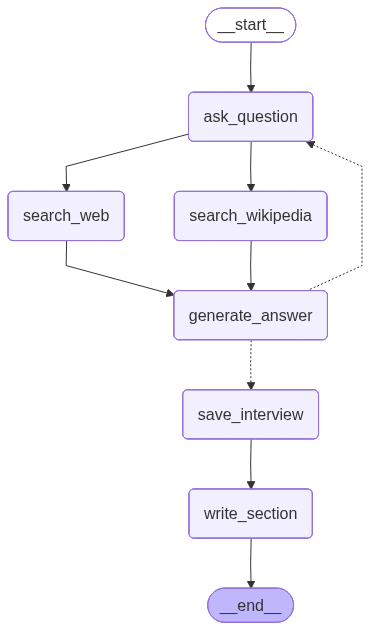

In [214]:

display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [215]:

analyst

Analyst(name='Michael Thompson', role='Business Process Optimization Consultant', affiliation='Efficiency Solutions Ltd.', description="Michael's focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs.")

In [216]:
analyst.persona

"Name: Michael Thompson\nRole: Business Process Optimization Consultant\nAffiliation: Efficiency Solutions Ltd.\nDescription: Michael's focus is on optimizing business processes through technology. He evaluates how Langraph can be used to automate and improve business workflows, leading to increased efficiency and cost savings. Michael is interested in the practical applications of Langraph in various industries and how it can be tailored to meet specific business needs.\n"

In [217]:

thread = {"configurable": {"thread_id": "1"}}

In [218]:

from IPython.display import Markdown

In [219]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [220]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langraph applications in business process optimization across industries'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 search_docs::::::  [{'title': 'How to Automate Business Processes with LangGraph in 2026 | 01', 'url': 'https://vocal.media/01/how-to-automate-business-processes-with-lang-graph-in-2026', 'content': "To justify and optimize your LangGraph deployments, establish clear metrics from the start. Based on 2025 industry data, these are the KPIs that matter most.\n\nAutomation Rate\n\nTrack what percentage of cases your workflow handles end-to-end without human intervention. Industry benchmarks show that well-designed LangGraph workflows achieve 70-85% automation rates for routine processes, with the remaining 15-30% requiring human review for edge cases or high-stakes decisions.\n\nProcessing Time [...] Different industries are finding unique ways to leverage LangGraph for their specific challenges. Understanding these use cases can inspire your own implementations.\n\nHealthcare: Clinical Documentation and Patient Monitoring [...] This capability has made LangGraph the orchestration framewo

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content='Certainly, Langraph has been applied across various industries to optimize business processes and improve efficiency. Here are a few examples:\n\n1. **Healthcare**: Langraph is used for clinical documentation and patient monitoring. It serves as an orchestration framework for building production AI agents, which helps coordinate specialized agents working on complex tasks. This capability is particularly beneficial in healthcare, where reliability and auditability are crucial [1].\n\n2. **Manufacturing**: In the manufacturing sector, Langraph optimizes processes by analyzing production data in real-time to identify bottlenecks and suggest enhancements. It also offers predictive maintenance capabilities, allowing manufacturers to schedule repairs proactively, thus preventing failures and ensuring seamless operations. Additionally, it integrates with supply chain management to align production with inventory and customer demand, which is vital for efficient operations

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langraph reliability auditability features healthcare industry'
 search_docs::::::  [{'title': 'LangGraph vs LangChain: Choosing the Right Framework for AI ...', 'url': 'https://bigsteptech.com/blog/langgraph-vs-langchain', 'content': 'At BigStep Technologies, we use LangChain for rapid prototyping, like in our KnowledgeBase AI Chatbot with RAG capabilities.\n\nFor enterprise-scale workflows in finance and healthcare, LangGraph enables multi-step validation, data enrichment, and audit trails — making it ideal for traceable, intelligent automation across complex systems.\n\nPerformance and Scalability\n\nBoth frameworks are built for developers, but LangGraph pulls ahead in production environments where: [...] Tasks need retry mechanisms\n   Workflows span multiple tools and datasets\n   Asynchronous task management is important\n   You need low error rates with auditability\n\nLangChain, however, is faster for:\n\n   Testing ideas\n   Creat

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content="In the healthcare industry, Langraph ensures reliability and auditability through several key features and mechanisms:\n\n1. **Human-in-the-Loop Interventions**: Langraph allows for human oversight in workflows, which is crucial for handling edge cases or high-stakes decisions that require human judgment. This feature ensures that while automation is maximized, critical decisions can still be reviewed by healthcare professionals [1].\n\n2. **Memory Management and Transparency**: Langraph provides robust memory management capabilities, which are essential for maintaining a clear audit trail of decisions made by AI agents. This transparency is vital in healthcare, where understanding the rationale behind decisions can impact patient outcomes [1].\n\n3. **Error Handling and Robustness**: The framework includes error handling nodes and mechanisms to manage errors gracefully. This is particularly important in healthcare, where system failures can have serious consequence

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [221]:

Markdown(interview['sections'][0])

## Transforming Business Workflows with LangGraph: A Technological Revolution

### Summary

In the rapidly evolving landscape of business process optimization, LangGraph emerges as a pivotal technology, offering transformative solutions across various industries. As businesses strive to enhance efficiency and reduce costs, LangGraph provides a robust framework for automating and improving workflows. This report delves into the practical applications of LangGraph, highlighting its potential to revolutionize business processes through intelligent automation and seamless integration.

LangGraph's ability to automate routine processes with high efficiency is noteworthy. Industry benchmarks indicate that well-designed LangGraph workflows can achieve automation rates of 70-85%, significantly reducing the need for human intervention in routine tasks [1]. This high level of automation not only streamlines operations but also allows human resources to focus on more strategic, high-stakes decisions.

In the manufacturing sector, LangGraph optimizes processes by analyzing production data in real-time, identifying bottlenecks, and suggesting enhancements. Its predictive maintenance capabilities prevent failures and ensure seamless operations, aligning production with inventory and customer demand [2]. This integration is crucial for maintaining a competitive edge in a swiftly evolving market.

Healthcare is another industry where LangGraph has made significant inroads. It is used for clinical documentation and patient monitoring, providing a reliable framework for building production AI agents. The ability to manage memory, handle human-in-the-loop interventions, and offer transparency into agent decision-making makes LangGraph ideal for enterprise deployments where reliability and auditability are paramount [1].

LangGraph's versatility extends to the finance sector, where it enables multi-step validation, data enrichment, and audit trails, making it suitable for traceable, intelligent automation across complex systems [3]. This capability is crucial for industries that require high levels of accuracy and accountability.

Moreover, LangGraph's modular design supports scalability and adaptability, allowing businesses to tailor solutions to their specific needs. This flexibility is particularly beneficial in industries like healthcare, where systems must support diverse domains and maintain stringent auditability standards [4].

In conclusion, LangGraph stands out as a strategic advantage for businesses looking to optimize their processes through technology. Its ability to automate complex workflows, integrate seamlessly with existing systems, and provide reliable, scalable solutions makes it an invaluable tool for businesses aiming to enhance efficiency and reduce costs.

### Sources
[1] https://vocal.media/01/how-to-automate-business-processes-with-lang-graph-in-2026  
[2] https://www.indapoint.com/blog/langgraph-in-manufacturing-process-automation-revolutionizing-industry-with-intelligent-workflows.html  
[3] https://bigsteptech.com/blog/langgraph-vs-langchain  
[4] https://medium.com/@kofsitho/part-2-architecting-a-medical-ai-assistant-a-deep-dive-into-our-langgraph-powered-architecture-f17b51f8883d  

## Third Workflow

In [223]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [224]:
from langgraph.types import Send

In [225]:

def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,"messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]}) for analyst in state["analysts"]]

In [226]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [227]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [231]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [232]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [235]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}



In [234]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


In [238]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [239]:

memory = MemorySaver()

In [240]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

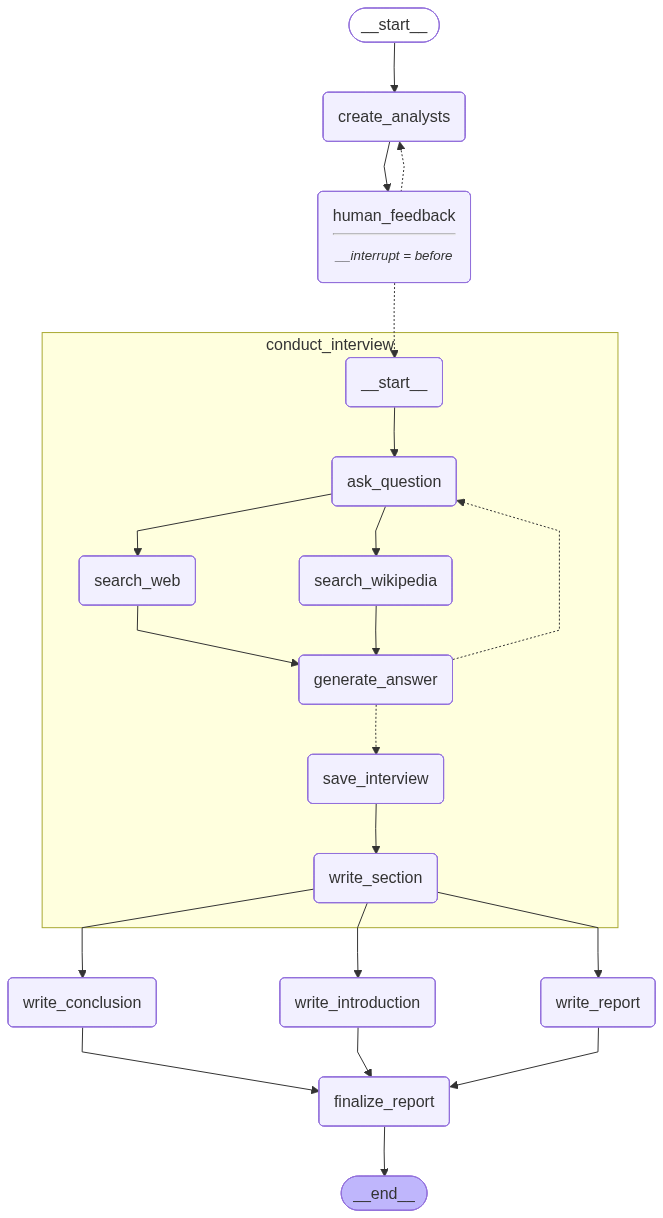

In [241]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [242]:
max_analysts = 3

In [243]:
topic = "How can generative help us to play the cricket?"

In [244]:

thread = {"configurable": {"thread_id": "1"}}

In [245]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Anjali Mehta
Affiliation: International Cricket Council (ICC)
Role: Sports Data Scientist
Description: Dr. Mehta focuses on how generative AI can be used to analyze player performance and strategy in cricket. She is particularly interested in using AI to simulate different match scenarios and predict outcomes, which can help teams to strategize better and improve their chances of winning.
--------------------------------------------------
Name: Rajiv Patel
Affiliation: Mumbai Cricket Association
Role: Cricket Coach and AI Enthusiast
Description: Rajiv is passionate about integrating technology into sports coaching. He explores how generative AI can assist in training cricketers by providing personalized feedback and creating virtual training environments. His goal is to enhance player skills and decision-making on the field through AI-driven insights.
--------------------------------------------------
Name: Emily Zhang
Affiliation: University of Sydney
Role: AI Ethics Researc

In [246]:

graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cbd8b-8b72-6437-8002-9c6222616ad6'}}

In [247]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anjali Mehta
Affiliation: International Cricket Council (ICC)
Role: Sports Data Scientist
Description: Dr. Mehta focuses on how generative AI can be used to analyze player performance and strategy in cricket. She is particularly interested in using AI to simulate different match scenarios and predict outcomes, which can help teams to strategize better and improve their chances of winning.
--------------------------------------------------
Name: Rajiv Patel
Affiliation: Mumbai Cricket Association
Role: Cricket Coach and AI Enthusiast
Description: Rajiv is passionate about integrating technology into sports coaching. He explores how generative AI can assist in training cricketers by providing personalized feedback and creating virtual training environments. His goal is to enhance player skills and decision-making on the field through AI-driven insights.
--------------------------------------------------
Name: Emily Zhang
Affiliation: University of Sydney
Role: AI Ethics Researc

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Anjali Mehta
Affiliation: Indian Institute of Technology, Delhi
Role: AI and Sports Integration Specialist
Description: Dr. Mehta focuses on how generative AI can be integrated into sports training and strategy development. Her work explores the potential of AI to enhance player performance, optimize team strategies, and provide real-time analytics during cricket matches. She is particularly interested in how AI can simulate various match scenarios to prepare teams for different challenges.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: ESPNcricinfo
Role: Cricket Analyst and Commentator
Description: Rajesh Kumar is a seasoned cricket analyst who examines the impact of technology on the game. He is interested in how generative AI can transform the way cricket is played and viewed, including the creation of virtual matches and predictive analytics for game outcomes. Rajesh also explores the cultural and ethical implications of AI in cricket, 

In [248]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cbd8e-0048-6e72-8006-0f0147952ee9'}}

In [249]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [250]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


search_query='current and future applications of generative AI in cricket'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='current use of AI in scouting new cricket talent in India'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how generative AI is used in cricket training and strategy development'
 search_docs::::::  [{'title': 'How AI is revolutionizing cricket: from coaching to nutrition - LinkedIn', 'url': 'https://www.linkedin.com/posts/rohitpandharkar_generativeai-activity-7385522583326121984-bc3x', 'content': "The fitness industry is entering a new era, and AI is the driving force. As discussed in this insightful article from Vocal Media, we're moving beyond generic apps into the age of truly smart, personalized workouts. At CrunchClone, we are building this future. Our generative AI technology empowers personal trainers and wellness coaches to scale their unique expertise, voice, and training methodology. We create personalized digital avatars that preserve a trainer’s authentic style, delivering [...] Our co-authored article on 𝗔𝗜 𝗶𝗻 𝗖𝗿𝗶𝗰𝗸𝗲𝘁 published today in 𝗹𝗲𝗮𝗱𝗶𝗻𝗴 𝗠𝗮𝗿𝗮𝘁𝗵𝗶 𝗻𝗲𝘄𝘀𝗽𝗮𝗽𝗲𝗿 𝗦𝗮𝗸𝗮𝗮𝗹 𝗦𝗮𝗽𝘁𝗮𝗿𝗮𝗻𝗴 supplement on Sunday 19 Oct 2025. (Sharing english tr

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content="Generative AI has been increasingly utilized in cricket to simulate various match scenarios, which significantly aids teams in preparing for different challenges. For instance, AI-powered platforms can analyze vast amounts of performance data to create personalized player profiles and provide coaching insights. This allows teams to simulate match conditions and strategize accordingly [3]. \n\nMoreover, AI can automate match reports and generate real-time insights, which are crucial for decision-making during live play and post-match analysis. This capability helps teams to adjust their strategies dynamically based on the evolving conditions of the game [4]. \n\nAdditionally, AI-driven analytics platforms, like IBM's Cricket IQ Analytics Platform, offer real-time insights across a wide range of parameters, including player fitness, mental readiness, and in-game dynamics. These insights are converted into natural-language recommendations for coaches and analysts, enha

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='real-time analytics generative AI impact on cricket match outcomes and team strategies'
 search_docs::::::  [{'title': 'The Role of AI in Cricket: Revolutionizing the Game | Xbeekon', 'url': 'https://xbeekon.com/the-role-of-ai-in-cricket-revolutionizing-the-game', 'content': 'The arrival of Generative AI is supercharging cricket analysis and simulations.\n\n Simulated Match Scenarios: AI models simulate real-world matches using historical and statistical data, helping teams prep for any situation.\n Virtual Training: Players now train against AI-generated opponents, improving performance without real-world fatigue.\n AI-Powered Commentary: Generative AI enhances commentary with real-time stats, comparisons, and analysis, creating a richer viewing experience. [...] Tools like Hawk-Eye and UltraEdge use AI to deliver precise, real-time ball tracking. This minimizes human error and enhances decision review systems (DRS) with higher accuracy an

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content="Generative AI provides real-time analytics during cricket matches by leveraging advanced data processing capabilities to analyze live match data and offer strategic insights. For example, AI tools can suggest field placements, bowling changes, or batting order tweaks in real time, ensuring that teams can adapt their strategies under pressure [6]. \n\nOne specific instance of this technology influencing a match's outcome is through AI-powered platforms like IBM's Cricket IQ Analytics Platform. This platform generates real-time insights across various parameters, such as player fitness and pitch conditions, and converts complex datasets into natural-language recommendations for coaches and analysts. These insights enable teams to make intelligent decisions both during live play and in post-match analysis, potentially altering the course of a match [5].\n\nAdditionally, AI-driven systems like Hawk-Eye and UltraEdge enhance decision review systems (DRS) by providing pre

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 1.152000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content='Generative AI is making significant strides in transforming the way cricket is played and viewed. Here are some specific examples and potential future applications:\n\n1. **Player Analysis and Performance Enhancement**: AI-driven platforms like ReelMind.ai are revolutionizing player analysis by providing deeper insights into player performance. For instance, the analysis of players like Dewald Brevis using AI can lead to performance enhancement by identifying strengths and weaknesses more accurately. These platforms use a vast library of AI models to produce engaging visual narratives and personalized content for fans [1].\n\n2. **Content Creation and Fan Engagement**: Automated systems powered by generative AI can generate content highlights from matches, celebrate player milestones, and engage fans with interactive content like quizzes and polls. This not only enhances the viewing experience but also keeps fans engaged with the sport in innovative ways [2].\n\n3. 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='ethical concerns of AI in cricket Indian team'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


answer:::: content="Generative AI is transforming the landscape of cricket in several ways, particularly in scouting new talent, enhancing training programs, and maintaining competitive edges. Here are some specific examples:\n\n1. **Scouting and Talent Identification**: AI is being used to identify new talent by analyzing vast amounts of data from various matches and player performances. This includes tracking player statistics, performance metrics, and even social media presence to identify potential future stars [3].\n\n2. **Player Performance Tracking & Analysis**: AI systems are capable of tracking player movements and performance in real-time, providing detailed analytics that can help in understanding a player's strengths and weaknesses. This data-driven approach allows coaches to tailor training programs to individual needs, enhancing player development [3].\n\n3. **Injury Prediction and Prevention**: AI can predict potential injuries by analyzing patterns in player movements a

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how AI enhances cricket training programs technologies methods'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


 search_docs::::::  [{'title': '[PDF] Transforming Indian Sports with AI and Data Science - IJCRT.org', 'url': 'https://www.ijcrt.org/papers/IJCRT24A4309.pdf', 'content': "4. Address Regulatory and Privacy Concerns: The use of AI in sports raises important questions around data privacy, athlete monitoring, and fairness. To address these concerns; Collaborate with policymakers and regulatory bodies to develop clear guidelines and policies governing the use of AI in sports; Establish robust data governance frameworks to ensure the ethical and responsible use of athlete data and AI-powered insights; Engage with athletes, coaches, and other stakeholders to address [...] resistant to new technologies, preferring to rely on traditional scouting, coaching, and training methods. Overcoming inertia and getting stakeholders to embrace AI-powered innovations has been difficult. Regulatory and privacy concerns: The use of AI in sports raises important questions around data privacy, athlete monitor

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.390513 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.910430 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


--Node--
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.425019 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 0.786902 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-N5jCdFOwg7AbgJgJ44UHXd3f on tokens per min (TPM): Limit 30000, Requested 36159. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [251]:

final_state = graph.get_state(thread)

In [254]:
final_state.values

{'topic': 'How can generative help us to play the cricket?',
 'max_analysts': 3,
 'human_analyst_feedback': '',
 'analysts': [Analyst(name='Dr. Anjali Mehta', role='AI and Sports Integration Specialist', affiliation='Indian Institute of Technology, Delhi', description='Dr. Mehta focuses on how generative AI can be integrated into sports training and strategy development. Her work explores the potential of AI to enhance player performance, optimize team strategies, and provide real-time analytics during cricket matches. She is particularly interested in how AI can simulate various match scenarios to prepare teams for different challenges.'),
  Analyst(name='Rajesh Kumar', role='Cricket Analyst and Commentator', affiliation='ESPNcricinfo', description='Rajesh Kumar is a seasoned cricket analyst who examines the impact of technology on the game. He is interested in how generative AI can transform the way cricket is played and viewed, including the creation of virtual matches and predictiv

In [255]:
report = final_state.values.get('final_report')

In [256]:
report

In [257]:

Markdown(report)

<IPython.core.display.Markdown object>